### loading model

In [1]:
import torch
from dataclasses import dataclass
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from PIL import Image
import math
import matplotlib.pylab as plt

%matplotlib inline

In [11]:
@dataclass
class vit_config:
    num_channels: int = 3
    batch_size:int = 16
    image_size: int = 224
    patch_size: int = 16
    num_heads:int = 8
    dropout: float = 0.0
    hidden_size: int = 768
    layer_norm_eps: float = 1e-6
    num_encoder_layers: int = 12
    random_seed: int = 42
    epochs: int = 30
    num_classes: int = 10              # will be replaced during data preprocess
    learning_rate: float = 1e-5
    adam_weight_decay: int = 0
    adam_betas: tuple = (0.9, 0.999)
    embd_dim: int = (patch_size ** 2) * num_channels           # 768
    num_patches: int = (image_size // patch_size) ** 2         # 196
    device: str = "cuda" if torch.cuda.is_available() else "cpu" 
    
config = vit_config

class VisionEmbedding(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()
        
        self.config  = config
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(
                in_channels=config.num_channels,
                out_channels=config.embd_dim,
                kernel_size=config.patch_size,
                stride=config.patch_size,
                padding="valid"
            ),
            nn.Flatten(start_dim=2)
        )
        
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, config.embd_dim)), requires_grad=True)
        self.pos_embeddings = nn.Parameter(torch.randn(size=(1, config.num_patches + 1, config.embd_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=config.dropout)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        patch_embd = self.patch_embedding(x).transpose(2,1)
        patch_embd = torch.cat([cls_token, patch_embd], dim=1)
        embd = self.pos_embeddings + patch_embd
        embd = self.dropout(embd)
        return embd
    
class VisionAttention(nn.Module):
    def __init__(self, config:vit_config):
        super().__init__()
        
        self.embd_dim = config.embd_dim
        self.num_heads = config.num_heads
        self.dropout = config.dropout
        
        self.q_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.k_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.v_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        
        query = self.q_proj(x)
        key = self.k_proj(x)
        value = self.v_proj(x)
        
        query = query.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        key = key.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        value = value.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        
        attn_score = (query @ key.transpose(-2, -1)) * (1.0 / math.sqrt(key.size(-1)))
        attn_score = F.softmax(attn_score, dim=-1).to(query.dtype)
        
        attn_out = (attn_score @ value).transpose(1,2)
        attn_out = attn_out.reshape(B, T, C).contiguous()
        attn_out = self.out_proj(attn_out)
        attn_out = F.dropout(attn_out, p=self.dropout, training=self.training)
        
        return attn_out
        
    
class VisionMLP(nn.Module):
    def __init__(self, config:vit_config):
        super().__init__()
        
        self.layer1 = nn.Linear(config.embd_dim, 3 * config.embd_dim)
        self.layer2 = nn.Linear(3 * config.embd_dim, config.embd_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = nn.functional.gelu(x, approximate="tanh")
        x = self.layer2(x)
        return x
    
class VisionEncoderLayer(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()
        
        self.embd_dim = config.embd_dim
        self.attn = VisionAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        self.mlp = VisionMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x
class VisionEncoder(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()
        self.layers = nn.ModuleList([VisionEncoderLayer(config) for _ in range(config.num_encoder_layers)])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x
    
class VisionTransformer(nn.Module):
    def __init__(self, config= vit_config):
        super().__init__()
        
        self.embedding = VisionEmbedding(config)
        self.encoder = VisionEncoder(config)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(config.embd_dim, eps=config.layer_norm_eps),
            nn.Linear(config.embd_dim, config.num_classes)
        )
        
    def forward(self, x:torch.Tensor ) -> torch.Tensor:
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.mlp_head(x[:, 0, :])
        return x

In [12]:
inference_model = VisionTransformer(vit_config)

In [13]:
inference_model = torch.load('vision_transformer_flowers_full.pth', weights_only=False)
inference_model.eval()
inference_model.to(config.device)

VisionTransformer(
  (embedding): VisionEmbedding(
    (patch_embedding): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): VisionEncoder(
    (layers): ModuleList(
      (0-11): 12 x VisionEncoderLayer(
        (attn): VisionAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): VisionMLP(
          (layer1): Linear(in_features=768, out_features=2304, bias=True)
          (layer2): Linear(in_features=2304, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps

In [18]:
classes = ['balloon flower','camellia', 'clematis','geranium','japanese anemone','magnolia','purple coneflower','spring crocus','stemless gentian','trumpet creeper']

In [36]:
def predict(image_path, model,classes):
    """
        Predict flower class from an image
    """
    
    try:
        transform = transforms.Compose([
            transforms.Resize((config.image_size, config.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        # Load and transform image
        img = Image.open(image_path).convert('RGB')
        image = transform(img).unsqueeze(0).to(config.device)
        
        # Print shape for debugging
        print(f"Transformed image shape: {image.shape}")
        
        with torch.no_grad():
            out = model(image)
            probabilities = F.softmax(out, dim=1)
            pred = torch.argmax(probabilities, dim=1)
            
        pred_class = classes[pred.item()]
        confidence = probabilities[0][pred.item()].item()
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image[0].cpu().permute(1, 2, 0).numpy())
        plt.title(f"Prediction: {pred_class}\nConfidence: {confidence:.4f}")
        plt.axis('off')
            
        # Plot probability distribution
        plt.subplot(1, 2, 2)
        sorted_indices = torch.argsort(probabilities[0], descending=True).cpu().numpy()
        top_classes = [classes[i] for i in sorted_indices[:5]]
        top_probs = [probabilities[0][i].item() for i in sorted_indices[:5]]
        
        plt.bar(range(len(top_classes)), top_probs)
        plt.xticks(range(len(top_classes)), top_classes, rotation=45)
        plt.title("Top 5 Class Probabilities")
        plt.tight_layout()
        plt.show()
        
        return pred_class, confidence
    
    except Exception as e:
        raise e
    

### original label : geranium

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Salus X Labs\AppData\Local\Temp\ipykernel_25144\2346005066.py:1: SyntaxWarning: invalid escape sequence '\i'
  image_path = "inference\image_02647_jpg.rf.ef01491d5e51acb96500738b675b7019.jpg"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8550389].


Transformed image shape: torch.Size([1, 3, 224, 224])


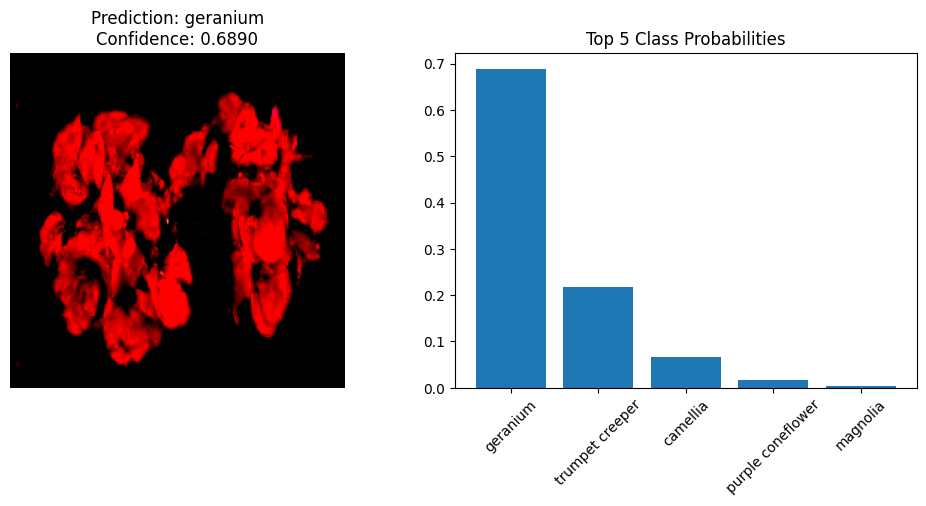

Predicted: geranium with 68.90% confidence


In [37]:
image_path = "inference\image_02647_jpg.rf.ef01491d5e51acb96500738b675b7019.jpg"
class_name, conf = predict(image_path, inference_model, classes)
print(f"Predicted: {class_name} with {conf*100:.2f}% confidence")

### original label : spring crocus

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Salus X Labs\AppData\Local\Temp\ipykernel_25144\600371387.py:1: SyntaxWarning: invalid escape sequence '\i'
  image_path = "inference\image_07048_jpg.rf.0234d48313e08b3426323e5731f96737.jpg"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.64].


Transformed image shape: torch.Size([1, 3, 224, 224])


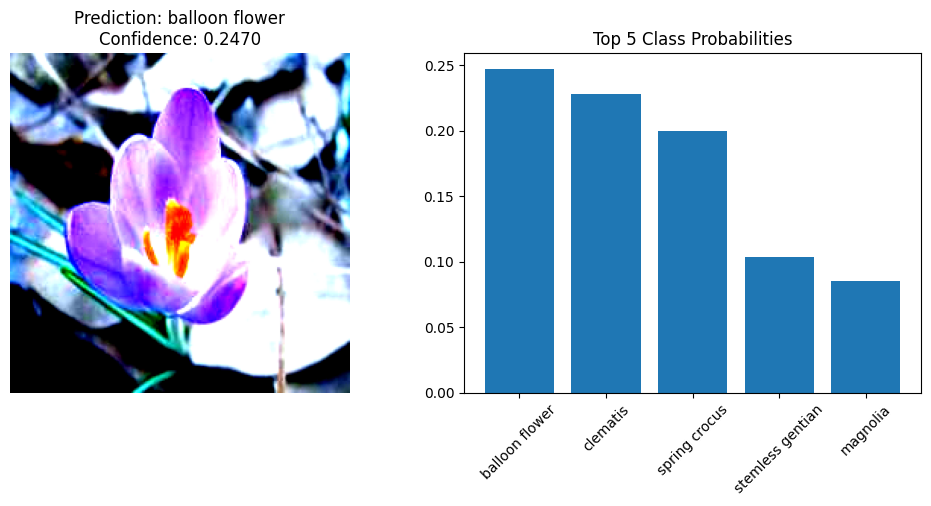

Predicted: balloon flower with 24.70% confidence


In [38]:
image_path = "inference\image_07048_jpg.rf.0234d48313e08b3426323e5731f96737.jpg"
class_name, conf = predict(image_path, inference_model, classes)
print(f"Predicted: {class_name} with {conf*100:.2f}% confidence")

### original label : trumpet creeper

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Salus X Labs\AppData\Local\Temp\ipykernel_25144\2142576902.py:1: SyntaxWarning: invalid escape sequence '\i'
  image_path = "inference\image_07954_jpg.rf.484d5fa03ea5408e09ec7ad03b5b3bcb.jpg"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].


Transformed image shape: torch.Size([1, 3, 224, 224])


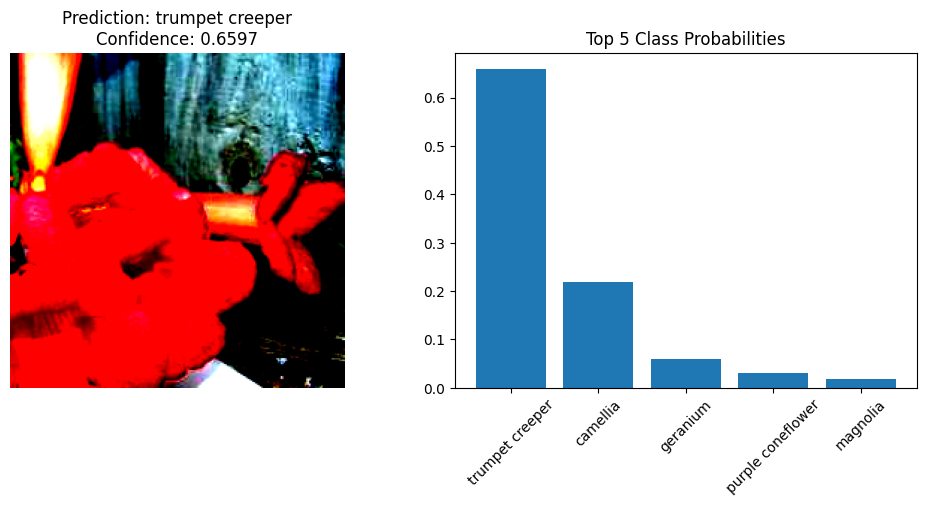

Predicted: trumpet creeper with 65.97% confidence


In [39]:
image_path = "inference\image_07954_jpg.rf.484d5fa03ea5408e09ec7ad03b5b3bcb.jpg"
class_name, conf = predict(image_path, inference_model, classes)
print(f"Predicted: {class_name} with {conf*100:.2f}% confidence")